Section 1: Defining some general parameters and importing the libraries.

In [1]:
# Importing the libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfreqz, sosfilt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC  # Import Support Vector Classification from scikit-learn
from sklearn.neural_network import MLPClassifier  # Import Multi-layer Perceptron classifier from scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import umap.umap_ as umap

NumSegEpoch_Test=42      #Number of segments in each epoch (for testing session)
NumSegEpoch_Train=34     #Number of segments in each epoch (for training session)
NumAllSeg_Test=1890           #Number of all recorded segments for test set 
NumAllSeg_Train=612            #Number of all recorded segments for train set 
NumAllSegSeq=540         #Number of segments that we have for each stimulus sequence
segment_sam=252          #The length of each cVEP segment 
NumContinousSeg=6        #Number of segments that are shown continously
NumSequence=3            #Number of reference sequences
NumTarget=6              #Number of targets for each stimulus sequence
NumTargetSegment=90      #Number of EEG segments we have for each stimulus target
SampleRate=250           #Sample rate of the EEG recorder

#Order of stimulus sequences while they were shown to the subjects 
SequenceOrder_Test=np.array([3,1,2,3,2,1,1,2,3,2,1,3,2,3,1,1,2,3,3,1,2,1,2,3,1,3,2,3,1,2,2,3,1,1,2,3,2,1,3,1,3,2,3,1,2])

#Order of visual targets which are shown for each visual stimulus sequence (first row is for stimulus sequence 1 and so on)
TargetOrder=np.array([[3,4,2,5,6,1,4,2,6,1,5,3,2,1,3,6,5,4,2,4,6,3,5,1,5,4,6,1,2,3,2,1,5,3,4,6,2,6,5,4,3,1,3,1,4,5,2,6,1,6,3,4,2,5,2,6,1,3,5,4,2,3,6,1,5,4,3,2,6,5,4,1,6,1,3,2,4,5,2,6,1,3,4,5,1,3,4,6,5,2],
                      [2,4,5,1,6,3,2,3,5,1,4,6,1,4,2,3,6,5,5,1,3,6,2,4,5,1,6,4,3,2,4,3,2,6,1,5,2,4,3,5,6,1,4,6,3,2,5,1,6,2,1,3,4,5,6,5,4,1,2,3,3,2,1,4,6,5,3,5,1,2,6,4,2,1,5,6,3,4,5,6,2,3,4,1,1,2,6,5,3,4],
                      [6,3,5,1,2,4,1,5,3,4,2,6,3,1,2,6,5,4,1,3,2,5,6,4,6,2,3,4,1,5,3,6,4,5,1,2,3,2,1,6,4,5,2,4,3,1,6,5,2,5,3,6,1,4,4,3,2,5,1,6,4,2,6,3,5,1,1,3,4,5,2,6,6,4,5,1,2,3,6,4,2,5,1,3,3,2,1,5,6,4]])

#Determine the order of sequences for the train set
SequenceOrder_Train=[3,1,2,3,2,1,1,2,3,2,1,3,2,3,1,1,2,3]

c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Section2: Reading the Test data in Python

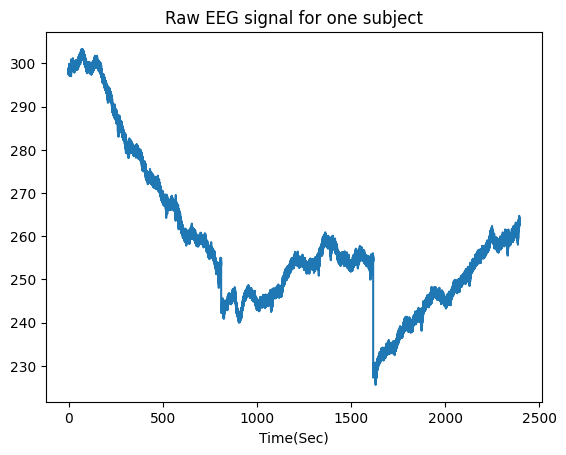

In [2]:
InputData=loadmat('S15_testing.mat')
AllData_Test=InputData['testing_data']

Synch_Sig_Test=AllData_Test[0,:]   # Synchronization signal
EEG_Sig_Test=AllData_Test[1,:]     # EEG data

num_samples=len(EEG_Sig_Test)
total_duration=num_samples/SampleRate #Total duration in second
time_vector_test=np.arange(0,total_duration,1/SampleRate) # Create a time vector

plt.plot(time_vector_test,EEG_Sig_Test)
plt.xlabel('Time(Sec)')
plt.title('Raw EEG signal for one subject')
plt.show()

Section3: Reading the train data in python

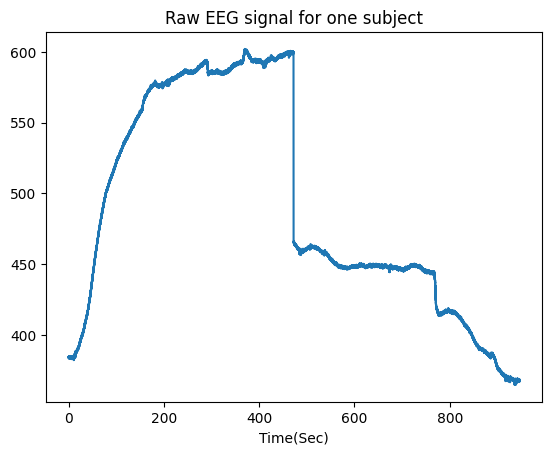

In [3]:
InputData=loadmat('S15_training.mat')
AllData_Train=InputData['training_data']

Synch_Sig_Train=AllData_Train[0,:]   # Synchronization signal
EEG_Sig_Train=AllData_Train[1,:]     # EEG data

num_samples=len(EEG_Sig_Train)
total_duration=num_samples/SampleRate #Total duration in second
time_vector_train=np.arange(0,total_duration,1/SampleRate) # Create a time vector

plt.plot(time_vector_train,EEG_Sig_Train)
plt.xlabel('Time(Sec)')
plt.title('Raw EEG signal for one subject')
plt.show()

Section4: Filtering the EEG signal for the test signals

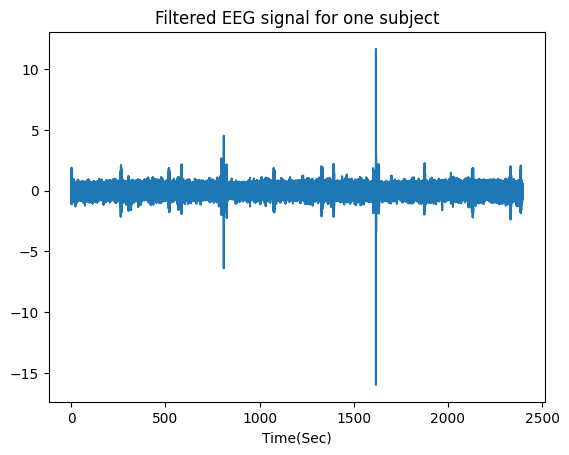

In [4]:
# Function to create a bandpass filter
def butter_bandpass(lowcut,highcut,fs,order):
    nyquist=0.5*fs
    low=lowcut/nyquist
    high=highcut/nyquist
    sos=butter(order,[low,high],btype='band',analog=False, output='sos')
    return sos

# Function to apply the bandpass filter to a signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    sos=butter_bandpass(lowcut,highcut,fs,order)
    y=sosfilt(sos,data)
    return y

# Defining the parameters of the bandpass filter  
Lowcut_Freq=2      #Low cutoff frequency
Highcut_Freq=40    #High cutoff frequency
FilterOrder=8      #Order of filter

# Apply bandpass filter
Filtered_EEG_Sig_Test=butter_bandpass_filter(EEG_Sig_Test,Lowcut_Freq,Highcut_Freq,SampleRate,FilterOrder)

# Plot the filtered EEG signal
plt.plot(time_vector_test[500:],Filtered_EEG_Sig_Test[500:])
plt.xlabel('Time(Sec)')
plt.title('Filtered EEG signal for one subject') 
plt.show()   

Section5: Filtering the EEG signal for the train signals

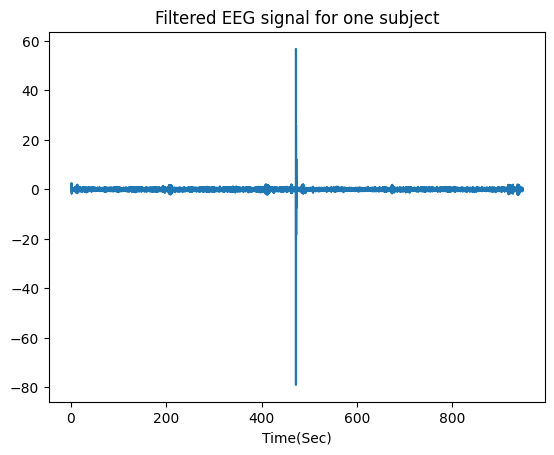

In [5]:
# Defining the parameters of the bandpass filter  
Lowcut_Freq=2      #Low cutoff frequency
Highcut_Freq=40    #High cutoff frequency
FilterOrder=8      #Order of filter

# Function to create a bandpass filter
def butter_bandpass(lowcut,highcut,fs,order):
    nyquist=0.5*fs
    low=lowcut/nyquist
    high=highcut/nyquist
    sos=butter(order,[low,high],btype='band',analog=False, output='sos')
    return sos

# Function to apply the bandpass filter to a signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    sos=butter_bandpass(lowcut,highcut,fs,order)
    y=sosfilt(sos,data)
    return y

# Apply bandpass filter
Filtered_EEG_Sig_Train=butter_bandpass_filter(EEG_Sig_Train,Lowcut_Freq,Highcut_Freq,SampleRate,FilterOrder)

# Plot the filtered EEG signal
plt.plot(time_vector_train[500:],Filtered_EEG_Sig_Train[500:])
plt.xlabel('Time(Sec)')
plt.title('Filtered EEG signal for one subject') 
plt.show()

Section 6: Extracting the EEG segments for the test signals

In [6]:
# Transform the synchronization signal to a binary signal 
SubjThresh=14.1
Synch_Sig_Binary_Test=np.zeros(len(Synch_Sig_Test))
for i in range(len(Synch_Sig_Test)):
    if Synch_Sig_Test[i] >= SubjThresh:
        Synch_Sig_Binary_Test[i]=1
    else:
        Synch_Sig_Binary_Test[i]=0

#plt.plot(Synch_Sig_Binary)

# Determine the onset of each EEG segment in the EEG signal 
def Segment_Onset(Synch_Sig):
    y=[]
    for i in range(1,len(Synch_Sig)):
        if Synch_Sig[i]-Synch_Sig[i-1]==1:
            y=y+[i]
    return y
Segment_Onset_Index=Segment_Onset(Synch_Sig_Binary_Test)
#print('Onset index of EEG segments: ',Segment_Onset_Index)

# Determine the label of each EEG segment based on our three reference stimulus sequences (1:m-sequence, 2:TFO, 3:6TO)
SegmentLabelSeq=np.array([])
for i in range(len(SequenceOrder_Test)):
    SegmentLabelSeq=np.concatenate((SegmentLabelSeq , np.repeat(SequenceOrder_Test[i],NumSegEpoch_Test)))
SegmentLabelSeq=np.array(SegmentLabelSeq.reshape(NumAllSeg_Test,1))
print('Size of the vector containing the labels of EEG segments: ', np.shape(SegmentLabelSeq))

# Produce an array in which each row is one EEG segment. The order of rows is based on the array which contains the EEG segments.
SegmentArray=np.zeros((NumAllSeg_Test,segment_sam))
for i in range(NumAllSeg_Test):
    SegmentArray[i,:]=Filtered_EEG_Sig_Test[Segment_Onset_Index[i]:(Segment_Onset_Index[i]+segment_sam)]
    MeanValue=np.mean(SegmentArray[i,:])
    SegmentArray[i,:]=SegmentArray[i,:]-MeanValue
print('Size of the array containing all the EEG segments: ',np.shape(SegmentArray))

# Extracting the EEG segments related to each reference stimulus sequence m-sequence, TFO, and 6TO and put them beside each other in individial arrays. (1:m-sequence, 2:TFO, 3:6TO)
# I used the label vector and EEG array which was produced previously for organizing the EEG segments
StimSeq1_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 1))  # Extracting the indices of EEG segments related to stimulus sequence 1 (m-sequence)
StimSeq1_AllSegments_Test=SegmentArray[StimSeq1_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 1 (m-sequence)
print('Size of the array containing EEG segments related to stimulus sequence 1:',np.shape(StimSeq1_AllSegments_Test))

StimSeq2_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 2))  # Extracting the indices of EEG segments related to stimulus sequence 2 (TFO)
StimSeq2_AllSegments_Test=SegmentArray[StimSeq2_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 2 (TFO) 

StimSeq3_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 3))  # Extracting the indices of EEG segments related to stimulus sequence 3 (6TO)
StimSeq3_AllSegments_Test=SegmentArray[StimSeq3_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 3 (6TO)

Size of the vector containing the labels of EEG segments:  (1890, 1)
Size of the array containing all the EEG segments:  (1890, 252)
Size of the array containing EEG segments related to stimulus sequence 1: (630, 252)


Section 7: Extracting the EEG segments for the train signals

In [7]:
# Transform the synchronization signal to a binary signal 
SubjThresh=13.7
Synch_Sig_Binary_Train=np.zeros(len(Synch_Sig_Train))
for i in range(len(Synch_Sig_Train)):
    if Synch_Sig_Train[i] >= SubjThresh:
        Synch_Sig_Binary_Train[i]=1
    else:
        Synch_Sig_Binary_Train[i]=0

#plt.plot(Synch_Sig_Binary)

# Determine the onset of each EEG segment in the EEG signal 
def Segment_Onset(Synch_Sig):
    y=[]
    for i in range(1,len(Synch_Sig)):
        if Synch_Sig[i]-Synch_Sig[i-1]==1:
            y=y+[i]
    return y
Segment_Onset_Index=Segment_Onset(Synch_Sig_Binary_Train)
#print('Onset index of EEG segments: ',Segment_Onset_Index)

# Determine the label of each EEG segment based on our three reference stimulus sequences (1:m-sequence, 2:TFO, 3:6TO)
SegmentLabelSeq=np.array([])
for i in range(len(SequenceOrder_Train)):
    SegmentLabelSeq=np.concatenate((SegmentLabelSeq , np.repeat(SequenceOrder_Train[i],NumSegEpoch_Train)))
SegmentLabelSeq=np.array(SegmentLabelSeq.reshape(NumAllSeg_Train,1))
print('Size of the vector containing the labels of EEG segments: ', np.shape(SegmentLabelSeq))

# Produce an array in which each row is one EEG segment. The order of rows is based on the array which contains the EEG segments.
SegmentArray=np.zeros((NumAllSeg_Train,segment_sam))
for i in range(NumAllSeg_Train):
    SegmentArray[i,:]=Filtered_EEG_Sig_Train[Segment_Onset_Index[i]:(Segment_Onset_Index[i]+segment_sam)]
    MeanValue=np.mean(SegmentArray[i,:])
    SegmentArray[i,:]=SegmentArray[i,:]-MeanValue
print('Size of the array containing all the EEG segments: ',np.shape(SegmentArray))

# Extracting the EEG segments related to each reference stimulus sequence m-sequence, TFO, and 6TO and put them beside each other in individial arrays. (1:m-sequence, 2:TFO, 3:6TO)
# I used the label vector and EEG array which was produced previously for organizing the EEG segments
StimSeq1_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 1))  # Extracting the indices of EEG segments related to stimulus sequence 1 (m-sequence)
StimSeq1_AllSegments_Train=SegmentArray[StimSeq1_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 1 (m-sequence)
print('Size of the array containing EEG segments related to stimulus sequence 1:',np.shape(StimSeq1_AllSegments_Train))

StimSeq2_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 2))  # Extracting the indices of EEG segments related to stimulus sequence 2 (TFO)
StimSeq2_AllSegments_Train=SegmentArray[StimSeq2_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 2 (TFO) 

StimSeq3_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 3))  # Extracting the indices of EEG segments related to stimulus sequence 3 (6TO)
StimSeq3_AllSegments_Train=SegmentArray[StimSeq3_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 3 (6TO)

Size of the vector containing the labels of EEG segments:  (612, 1)
Size of the array containing all the EEG segments:  (612, 252)
Size of the array containing EEG segments related to stimulus sequence 1: (204, 252)


Section 8: Eliminating the EEG segments related to gaze shifting for the testing data

In [8]:
RemovedIndices=list(range(0,629,7))   #Extracting the indices related to EEG segments specified for gaze shifting for each visual stimulus
StimSeq1_AllSegments=np.delete(StimSeq1_AllSegments_Test,RemovedIndices,axis=0)  #Removing the gaze shifting segments from the array containing the EEG segments related to stimulus sequence 1
StimSeq2_AllSegments=np.delete(StimSeq2_AllSegments_Test,RemovedIndices,axis=0)  #Removing the gaze shifting segments from the array containing the EEG segments related to stimulus sequence 2
StimSeq3_AllSegments=np.delete(StimSeq3_AllSegments_Test,RemovedIndices,axis=0)  #Removing the gaze shifting segments from the array containing the EEG segments related to stimulus sequence 3

print('Size of the array containing EEG segments related to stimulus sequence 1 after removing gaze shiftings',np.shape(StimSeq1_AllSegments))

Size of the array containing EEG segments related to stimulus sequence 1 after removing gaze shiftings (540, 252)


Section 9: Extracting the EEG segments related to each visual target of each stimulus sequence

In [9]:
# Determine the label of each EEG segment based on the label of visual target to which it is related
SegLabelTar_Seq1=np.array([])
SegLabelTar_Seq2=np.array([])
SegLabelTar_Seq3=np.array([])
for i in range(len(TargetOrder[0,:])):
    SegLabelTar_Seq1=np.concatenate((SegLabelTar_Seq1 , np.repeat(TargetOrder[0,i],NumContinousSeg)))
    SegLabelTar_Seq2=np.concatenate((SegLabelTar_Seq2 , np.repeat(TargetOrder[1,i],NumContinousSeg)))
    SegLabelTar_Seq3=np.concatenate((SegLabelTar_Seq3 , np.repeat(TargetOrder[2,i],NumContinousSeg)))

SegLabelTar_Seq1=np.array(SegLabelTar_Seq1.reshape(NumAllSegSeq,1))
SegLabelTar_Seq2=np.array(SegLabelTar_Seq2.reshape(NumAllSegSeq,1))
SegLabelTar_Seq3=np.array(SegLabelTar_Seq3.reshape(NumAllSegSeq,1))
print('The size of vector contaning the labels of EEG segments based on the label of visual targets for stimulus sequence 1:',np.shape(SegLabelTar_Seq1))

# Extracting the EEG segments related to each visual target for each stimulus sequence and then putting them beside each other
Seq1_OrganizedSegments=[0,0,0,0,0,0]
Seq2_OrganizedSegments=[0,0,0,0,0,0]
Seq3_OrganizedSegments=[0,0,0,0,0,0]
for i in range(1,7):
    Seq1_SegmentIndices=np.array(np.where(SegLabelTar_Seq1 == i))
    Seq1_OrganizedSegments[i-1]=StimSeq1_AllSegments[Seq1_SegmentIndices[0],:]

    Seq2_SegmentIndices=np.array(np.where(SegLabelTar_Seq2 == i))
    Seq2_OrganizedSegments[i-1]=StimSeq2_AllSegments[Seq2_SegmentIndices[0],:]

    Seq3_SegmentIndices=np.array(np.where(SegLabelTar_Seq3 == i))
    Seq3_OrganizedSegments[i-1]=StimSeq3_AllSegments[Seq3_SegmentIndices[0],:]
print('The size of array containing the EEG segments of one visual target of stimulus sequence 1',np.shape(Seq1_OrganizedSegments[0]))


The size of vector contaning the labels of EEG segments based on the label of visual targets for stimulus sequence 1: (540, 1)
The size of array containing the EEG segments of one visual target of stimulus sequence 1 (90, 252)


Section10: Visualizing the EEG signals for training part.

Text(0.5, 0, 'Samples')

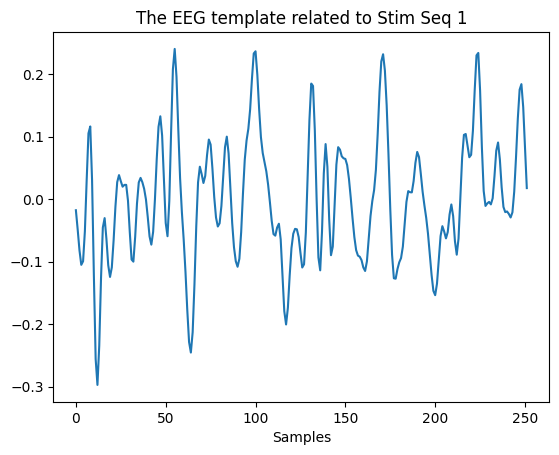

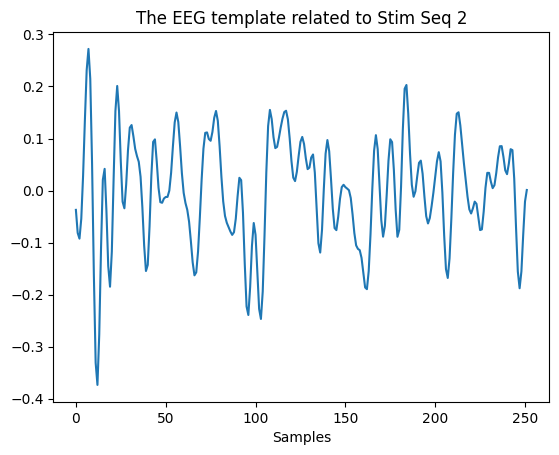

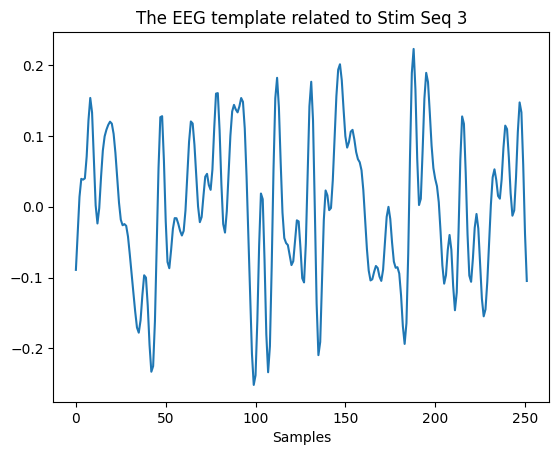

In [69]:
StimSeq1_Ref_temp=np.mean(StimSeq1_AllSegments_Train,axis=0)
StimSeq2_Ref_temp=np.mean(StimSeq2_AllSegments_Train,axis=0)
StimSeq3_Ref_temp=np.mean(StimSeq3_AllSegments_Train,axis=0)

plt.figure(1)
plt.plot(StimSeq1_Ref_temp)
plt.title('The EEG template related to Stim Seq 1')
plt.xlabel('Samples')

plt.figure(2)
plt.plot(StimSeq2_Ref_temp)
plt.title('The EEG template related to Stim Seq 2')
plt.xlabel('Samples')

plt.figure(3)
plt.plot(StimSeq3_Ref_temp)
plt.title('The EEG template related to Stim Seq 3')
plt.xlabel('Samples')


Section 8: Producing the train set and test set and label vector for each stimulus sequence.

In [12]:
ShiftVal=np.array([44,0,-40,-84,-124,-168])

Seq1_Train_Data=np.roll(StimSeq1_AllSegments_Train,ShiftVal[0],axis=1)
Seq2_Train_Data=np.roll(StimSeq2_AllSegments_Train,ShiftVal[0],axis=1)
Seq3_Train_Data=np.roll(StimSeq3_AllSegments_Train,ShiftVal[0],axis=1)
Seq1_Train_Label=np.full(np.size(StimSeq1_AllSegments_Train,0),0).reshape(-1,1)
Seq2_Train_Label=np.full(np.size(StimSeq2_AllSegments_Train,0),0).reshape(-1,1)
Seq3_Train_Label=np.full(np.size(StimSeq3_AllSegments_Train,0),0).reshape(-1,1)

for i in range (1,NumTarget):
    Seq1_Train_Data=np.concatenate((Seq1_Train_Data,np.roll(StimSeq1_AllSegments_Train,ShiftVal[i],axis=1)),axis=0)
    Seq2_Train_Data=np.concatenate((Seq2_Train_Data,np.roll(StimSeq2_AllSegments_Train,ShiftVal[i],axis=1)),axis=0)
    Seq3_Train_Data=np.concatenate((Seq3_Train_Data,np.roll(StimSeq3_AllSegments_Train,ShiftVal[i],axis=1)),axis=0)
    Seq1_Train_Label=np.concatenate((Seq1_Train_Label,np.full(np.size(StimSeq1_AllSegments_Train,0),i).reshape(-1,1)),axis=0)
    Seq2_Train_Label=np.concatenate((Seq2_Train_Label,np.full(np.size(StimSeq2_AllSegments_Train,0),i).reshape(-1,1)),axis=0)
    Seq3_Train_Label=np.concatenate((Seq3_Train_Label,np.full(np.size(StimSeq3_AllSegments_Train,0),i).reshape(-1,1)),axis=0)


Seq1_Train_Label=Seq1_Train_Label.ravel()
Seq2_Train_Label=Seq2_Train_Label.ravel()
Seq3_Train_Label=Seq3_Train_Label.ravel()


Seq1_Test_Data=StimSeq1_AllSegments                # Train and Test set for stimulus sequence 1
Seq1_Test_Label=(SegLabelTar_Seq1-1).ravel()        # Label vector for stimulus sequence 1

Seq2_Test_Data=StimSeq2_AllSegments                # Train and Test set for stimulus sequence 2
Seq2_Test_Label=(SegLabelTar_Seq2-1).ravel()        # Label vector for stimulus sequence 2

Seq3_Test_Data=StimSeq3_AllSegments                # Train and Test set for stimulus sequence 3
Seq3_Test_Label=(SegLabelTar_Seq3-1).ravel()        # Label vector for stimulus sequence 3

print('The size of array containing the train data for stimulus sequence3:',np.shape(Seq3_Train_Data))
print('The size of vector containing the train labels for stimulus sequence3:',np.shape(Seq3_Train_Label))

print('The size of array containing the test data for stimulus sequence3:',np.shape(Seq3_Test_Data))
print('The size of vector containing the labels for stimulus sequence3:',np.shape(Seq3_Test_Label))

np.set_printoptions(threshold=np.inf)
print(Seq1_Train_Label)
print(Seq1_Test_Label)

The size of array containing the train data for stimulus sequence3: (1224, 252)
The size of vector containing the train labels for stimulus sequence3: (1224,)
The size of array containing the test data for stimulus sequence3: (540, 252)
The size of vector containing the labels for stimulus sequence3: (540,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1